# Approximate a simulated non-linear function

# Task
- Use fully connected network to approximate a simulated non-linear function

## Data Exploration

In [1]:
file_name = '/src/data/function_approximation/xy_data.csv'

import pandas as pd
import numpy as np
df = pd.read_csv(file_name, header=None)
print(df.shape)

(3, 2000)


In [2]:
np_vector = df.values.transpose()
print(type(np_vector))
print(np_vector.shape)
print(np_vector[:5])

<class 'numpy.ndarray'>
(2000, 3)
[[-0.058929   0.06417    0.33     ]
 [ 0.16602   -0.0084448  0.33     ]
 [ 0.50408    0.098609   0.5      ]
 [-0.63563    0.97851    0.       ]
 [-0.63486    0.92308    0.       ]]


min:-0.999560, max:0.997750, median:-0.036787, mean:-0.033911, std:0.581712, size:2000


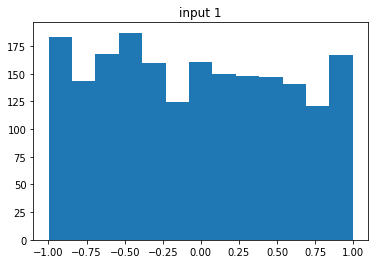

min:-0.999790, max:0.999340, median:-0.008641, mean:-0.007416, std:0.577141, size:2000


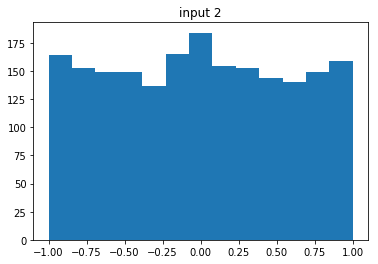

min:-0.500000, max:0.830000, median:0.000000, mean:0.034030, std:0.265202, size:2000


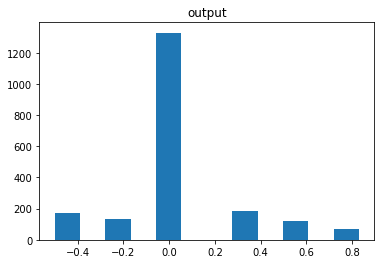

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

x = np_vector[:, 0]
y = np_vector[:, 1]
tk = np_vector[:,2]

def explore_vector(vector, title=None):
    assert type(vector) is np.ndarray
    assert vector.ndim == 1
    print('min:%f, max:%f, median:%f, mean:%f, std:%f, size:%d' 
          % (np.min(vector), np.max(vector), np.median(vector), np.mean(vector), np.std(vector), vector.size))
    plt.title(title)
    plt.hist(vector, bins='auto')
    plt.show()

explore_vector(x, "input 1")
explore_vector(y, "input 2")
explore_vector(tk, "output")

## Data Preparation

In [4]:
# Let's shuffle it
np.random.shuffle(np_vector)
print(np_vector[:5])

[[-0.7104   -0.58861   0.      ]
 [ 0.53067   0.98274   0.      ]
 [-0.88407   0.80603   0.      ]
 [ 0.88137  -0.20629   0.      ]
 [ 0.038365  0.92506  -0.5     ]]


In [ ]:
# separate input and output
input_vector = np_vector[:, :2]
print('input shape:' + str(input_vector.shape))
print(input_vector[:5])

output_vecotr = np_vector[:, 2]
print('output shape:' + str(output_vecotr.shape))
print(output_vecotr[:5])

input shape:(2000, 2)
[[-0.7104   -0.58861 ]
 [ 0.53067   0.98274 ]
 [-0.88407   0.80603 ]
 [ 0.88137  -0.20629 ]
 [ 0.038365  0.92506 ]]
output shape:(2000,)
[ 0.   0.   0.   0.  -0.5]


In [ ]:
pct_training = 0.9
pct_validation = 0.1

# separate training and test data
total_size = input_vector.shape[0]
training_size = int(total_size * pct_training)
test_size = total_size - training_size
val_size = int(training_size * pct_validation)

print('Total Size: %d, Train Size: %d, Validation Size: %d, Test Size: %d'
      % (total_size, training_size - val_size, val_size, test_size))

# slice data
train_in = input_vector[:training_size]
train_out = output_vecotr[:training_size]

test_in = input_vector[training_size:]
test_out = output_vecotr[training_size:]


val_in = train_in[:val_size]
val_out = train_out[:val_size]

train_in = train_in[val_size:]
train_out = train_out[val_size:]

print('train_in shape:' + str(train_in.shape))


Total Size: 2000, Train Size: 1620, Validation Size: 180, Test Size: 200
train_in shape:(1620, 2)


# Model Construction

In [ ]:
from keras import models
from keras import layers

# construct model
model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(2,)))
model.add(layers.Dense(32, activation='relu', input_shape=(2,)))
model.add(layers.Dense(32, activation='relu', input_shape=(2,)))
model.add(layers.Dense(32, activation='relu', input_shape=(2,)))
model.add(layers.Dense(16, activation='relu', input_shape=(2,)))
model.add(layers.Dense(16, activation='relu', input_shape=(2,)))
model.add(layers.Dense(16, activation='relu', input_shape=(2,)))
model.add(layers.Dense(8, activation='relu', input_shape=(2,)))
model.add(layers.Dense(1))

model.summary()

# custom metrics
import keras.backend as K

def max_diff(y_true, y_pred):
    return K.max(K.abs(y_pred-y_true))

def min_diff(y_true, y_pred):
    return K.min(K.abs(y_pred-y_true))

# compile model with optimizer, loss function
model.compile(optimizer='rmsprop',
              loss='mean_squared_error',
              metrics=[max_diff, min_diff])

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                96        
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_6 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_7 (Dense)              (None, 16)                272       
__________

In [ ]:
history = model.fit(train_in,
                    train_out,
                    epochs=100,
                    batch_size=32,
                    validation_data=(val_in, val_out))

Train on 1620 samples, validate on 180 samples
Epoch 1/100
1620/1620 [==============================] - 2s 1ms/step - loss: 0.0637 - max_diff: 0.6851 - min_diff: 0.0065 - val_loss: 0.0492 - val_max_diff: 0.5678 - val_min_diff: 2.1721e-04
Epoch 2/100
1620/1620 [==============================] - 0s 192us/step - loss: 0.0487 - max_diff: 0.5584 - min_diff: 0.0045 - val_loss: 0.0381 - val_max_diff: 0.4508 - val_min_diff: 0.0195
Epoch 3/100
1620/1620 [==============================] - 0s 207us/step - loss: 0.0391 - max_diff: 0.4680 - min_diff: 0.0083 - val_loss: 0.0377 - val_max_diff: 0.4714 - val_min_diff: 0.0120
Epoch 4/100
1620/1620 [==============================] - 0s 204us/step - loss: 0.0351 - max_diff: 0.4388 - min_diff: 0.0094 - val_loss: 0.0312 - val_max_diff: 0.4250 - val_min_diff: 0.0058
Epoch 5/100
1620/1620 [==============================] - 0s 211us/step - loss: 0.0342 - max_diff: 0.4500 - min_diff: 0.0057 - val_loss: 0.0285 - val_max_diff: 0.4126 - val_min_diff: 0.0039
Epoch 

In [ ]:
# check out history object
history_dict = history.history
history_dict.keys()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

max_diff = history.history['max_diff']
val_max_diff = history.history['val_max_diff']

min_diff = history.history['min_diff']
val_min_diff = history.history['val_min_diff']

epochs = range(1, len(loss) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
plt.clf()   # clear figure
plt.plot(epochs, max_diff, 'bo', label='Training max abs diff')
plt.plot(epochs, val_max_diff, 'r', label='Validation max abs diff')
plt.title('Training and Validation - Maximum Absolute Diff')
plt.xlabel('Epochs')
plt.ylabel('Abs Diff')
plt.legend()

plt.show()

In [ ]:
plt.clf()   # clear figure
plt.plot(epochs, min_diff, 'bo', label='Training min abs diff')
plt.plot(epochs, val_min_diff, 'r', label='Validation min abs diff')
plt.title('Training and Validation - Min Absolute Diff')
plt.xlabel('Epochs')
plt.ylabel('Abs diff')
plt.legend()

plt.show()

## Model Evaluation

In [ ]:
# evaulate model with test data
results = model.evaluate(test_in, test_out)
results

In [ ]:
pre_test_out = model.predict(test_in)
pre_test_out = pre_test_out.flatten()

In [ ]:
explore_vector(pre_test_out, 'Predicted Test Data Output')

In [ ]:
explore_vector(test_out, 'Test Data Output')

In [ ]:
plt.clf()   # clear figure
NUM_PLOT = 50
plt.plot(pre_test_out[:NUM_PLOT], 'bo', label='predicted test out')
plt.plot(test_out[:NUM_PLOT], 'ro', label='test out')
plt.title('Output Prediction Comparison')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
#plt.rcParams['figure.figsize'] = [20, 20]
#plt.figure(figsize=(20, 20), dpi= 20)
plt.show()

In [ ]:
abs_diff_test_out = abs(pre_test_out - test_out)
plt.clf()   # clear figure
explore_vector(abs_diff_test_out, 'Histogram of Absolute diff between predicted output and real output')

In [ ]:
plt.clf()   # clear figure
plt.plot(abs_diff_test_out, 'bo', label='abs diff test out')
plt.title('Output Prediction Comparison')
plt.xlabel('Element Index')
plt.ylabel('Abs Diff')
